# Install the necessary packages

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install holidays-es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read the data

In [5]:
# read the data
import pandas as pd
import numpy as np
from fbprophet import Prophet

traindf = pd.read_table("gdrive/MyDrive/data/dataset/train.csv", index_col = 0, sep = ",")
testdf = pd.read_table("gdrive/MyDrive/data/dataset/test.csv", index_col = 0, sep = ",")
#testdf = testdf[0:-1]

traindf['total load actual'] = traindf['total load actual'].astype('float64').fillna(method='bfill')
testdf['total load actual'] = testdf['total load actual'].astype('float64').fillna(method='bfill')

# Normalization and Formatting

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(traindf['total load actual'].values.reshape(-1,1))
traindf['actual'] = scaler.transform(traindf['total load actual'].values.reshape(-1, 1))
testdf['actual'] = scaler.transform(testdf['total load actual'].values.reshape(-1, 1))

In [7]:
traindf.index = traindf.index.astype("datetime64[ns]")
traindf.index = pd.DatetimeIndex(traindf.index.values,
                               freq=traindf.index.inferred_freq)

testdf.index = testdf.index.astype("datetime64[ns]")
testdf.index = pd.DatetimeIndex(testdf.index.values,
                               freq=testdf.index.inferred_freq)

In [8]:
trainProphet = pd.DataFrame({'ds':traindf.index.values, 'y':traindf['actual']})
testProphet = pd.DataFrame({'ds':testdf.index.values, 'y':testdf['actual']})

# Exogenous features selection

In [9]:
def customise_data(data):
  df = data.copy()

  #df['temp'] = train_df_daily['Valencia_temp'], train_df_daily['Madrid_temp'], train_df_daily['Bilbao_temp'], train_df_daily['Barcelona_temp'], train_df_daily['Seville_temp']
  df['temp'] = df[['Valencia_temp', 'Madrid_temp', 'Bilbao_temp', ' Barcelona_temp', 'Seville_temp']].mean(axis=1)
  df['temp_min'] = df[['Valencia_temp_min', 'Madrid_temp_min', 'Bilbao_temp_min', ' Barcelona_temp_min', 'Seville_temp_min']].mean(axis=1)
  df['temp_max'] = df[['Valencia_temp_max', 'Madrid_temp_max', 'Bilbao_temp_max', ' Barcelona_temp_max', 'Seville_temp_max']].mean(axis=1)
  df['pressure'] = df[['Valencia_pressure', 'Madrid_pressure', 'Bilbao_pressure', ' Barcelona_pressure', 'Seville_pressure']].mean(axis=1)
  df['humidity'] = df[['Valencia_humidity', 'Madrid_humidity', 'Bilbao_humidity', ' Barcelona_humidity', 'Seville_humidity']].mean(axis=1)
  df['wind_speed'] = df[['Valencia_wind_speed', 'Madrid_wind_speed', 'Bilbao_wind_speed', ' Barcelona_wind_speed', 'Seville_wind_speed']].mean(axis=1)
  df['wind_deg'] = df[['Valencia_wind_deg', 'Madrid_wind_deg', 'Bilbao_wind_deg', ' Barcelona_wind_deg', 'Seville_wind_deg']].mean(axis=1)
  df['rain_1h'] = df[['Valencia_rain_1h', 'Madrid_rain_1h', 'Bilbao_rain_1h', ' Barcelona_rain_1h', 'Seville_rain_1h']].mean(axis=1)
  df['snow_3h'] = df[['Valencia_snow_3h', 'Madrid_snow_3h', 'Bilbao_snow_3h', ' Barcelona_snow_3h', 'Seville_snow_3h']].mean(axis=1)
  df['clouds_all'] = df[['Valencia_clouds_all', 'Madrid_clouds_all', 'Bilbao_clouds_all', ' Barcelona_clouds_all', 'Seville_clouds_all']].mean(axis=1)
  df['weather_id'] = df[['Valencia_weather_id', 'Madrid_weather_id', 'Bilbao_weather_id', ' Barcelona_weather_id', 'Seville_weather_id']].mean(axis=1)
  return df[['total load actual','temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h', 'clouds_all', 'weather_id']]

def extract_from_date(data,time_column):
    
    data["year"]=data[time_column].dt.year
    data["quarter"]=data[time_column].dt.quarter
    data["month"]=data[time_column].dt.month
    data["week"]=data[time_column].dt.isocalendar().week
    #data["hour"]=data[time_column].dt.hour
    #data["time"]=data[time_column].dt.time
    data['dayofweek'] = data[time_column].dt.dayofweek
    data["dayofmonth"]=data[time_column].dt.day
    data["day_name"]=data[time_column].dt.day_name()
    data['is_weekend'] = np.where(data['day_name'].isin(['Sunday', 'Saturday']), 1,0)
    data["is_year_start"]=np.where(data[time_column].dt.is_year_start, 1, 0)
    
    return data.drop(columns=['day_name', 'Date'])

In [10]:
train_custom = customise_data(traindf)
test_custom = customise_data(testdf)


# Get CLND features to use for the models
train_custom['Date'] = traindf.index.values
test_custom['Date'] = testdf.index.values
train_df = extract_from_date(train_custom, 'Date')
test_df = extract_from_date(test_custom, 'Date')

# Get Holidays

In [11]:
trainHolidays = pd.DataFrame({'ds':traindf.index.values})
testHolidays = pd.DataFrame({'ds':testdf.index.values})

In [12]:
from pandas.core.indexes.api import all_indexes_same
from holidays_es import get_provinces, Province

years = range(2014, 2020)
provinces = ["valencia", "madrid", "bilbao", "barcelona", "sevilla"]
holidays = []

for one_year in years:
  for one_province in provinces:
    
    all_holidays = Province(name=one_province, year=one_year).holidays()
    holidays = holidays + all_holidays['local_holidays'] + all_holidays['national_holidays'] + all_holidays['regional_holidays']


holidays = np.unique(holidays)

In [13]:
import datetime

hourly_holidays = []

for one_holiday in holidays:
  for one_hour in range(0, 24):
    
    dt = datetime.datetime.combine(one_holiday, datetime.time(one_hour, 00, 00))
    hourly_holidays = hourly_holidays + [dt]


In [14]:
trainHolidays['is_holiday'] = trainHolidays['ds'].isin([d for d in hourly_holidays])
trainHolidays['holiday'] = "ES Holiday"
trainHolidays = trainHolidays[trainHolidays['is_holiday']]
trainHolidays.drop(['is_holiday'], axis=1)

testHolidays['is_holiday'] = testHolidays['ds'].isin([d for d in hourly_holidays])
testHolidays['holiday'] = "ES Holiday"
testHolidays = testHolidays[testHolidays['is_holiday']]
testHolidays.drop(['is_holiday'], axis=1)

,ds,holiday
102,2018-03-19 00:00:00,ES Holiday
103,2018-03-19 01:00:00,ES Holiday
104,2018-03-19 02:00:00,ES Holiday
105,2018-03-19 03:00:00,ES Holiday
106,2018-03-19 04:00:00,ES Holiday
...,...,...
6889,2018-12-26 19:00:00,ES Holiday
6890,2018-12-26 20:00:00,ES Holiday
6891,2018-12-26 21:00:00,ES Holiday
6892,2018-12-26 22:00:00,ES Holiday


In [15]:
# allProphet = pd.concat([trainProphet, testProphet], sort=False)
allHolidays = pd.concat([trainHolidays, testHolidays], sort=False)

In [17]:
trainProphet['dayofmonth'] = train_df['dayofmonth'].fillna(method='bfill')
trainProphet['pressure'] = train_df['pressure'].fillna(method='bfill')
trainProphet['dayofweek'] = train_df['dayofweek'].fillna(method='bfill')
trainProphet['humidity'] = train_df['humidity'].fillna(method='bfill')
trainProphet['temp_min'] = train_df['temp_min'].fillna(method='bfill')
trainProphet['temp_max'] = train_df['temp_max'].fillna(method='bfill')

# Train model with added regressors
We select the features that showed the highest scores using LightGBM


In [26]:
m = Prophet(seasonality_mode='multiplicative', holidays = allHolidays, uncertainty_samples =0)

m.add_regressor('temp_min')
m.add_regressor('temp_max')
m.add_regressor('humidity')
m.add_regressor('pressure')
m.add_regressor('dayofmonth')
m.add_regressor('dayofweek')

res = m.fit(trainProphet)

step = 24
predictions = list()
observations = list()

In [25]:
future = res.make_future_dataframe(freq='H',periods = testProphet.shape[0])

future['temp_min'] = pd.concat([train_df['temp_min'], test_df['temp_min'].fillna(method='bfill')]).reset_index(drop = True)
future['temp_max'] = pd.concat([train_df['temp_max'], test_df['temp_max'].fillna(method='bfill')]).reset_index(drop = True)
future['humidity'] = pd.concat([train_df['humidity'], test_df['humidity'].fillna(method='bfill')]).reset_index(drop = True)
future['pressure'] = pd.concat([train_df['pressure'], test_df['pressure'].fillna(method='bfill')]).reset_index(drop = True)
future['dayofmonth'] = pd.concat([train_df['dayofmonth'], test_df['dayofmonth'].fillna(method='bfill')]).reset_index(drop = True)
future['dayofweek'] = pd.concat([train_df['dayofweek'], test_df['dayofweek'].fillna(method='bfill')]).reset_index(drop = True)


output = res.predict(future)

from math import sqrt
from sklearn.metrics import mean_squared_error

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = mean_squared_error(forecast, actual)   # MSE
    rmse = sqrt(mean_squared_error(forecast, actual))  # RMSE
  
    
    return({'mape':mape, 'mae': mae, 'mse': mse, 'rmse':rmse})

print(forecast_accuracy(output.yhat.tail(testProphet.shape[0]).reset_index(drop = True), testProphet['y'].reset_index(drop = True)))  

{'mape': 0.2965983336725429, 'mae': 0.10347130788779704, 'mse': 0.01774053423857288, 'rmse': 0.1331935968377342}


# Train data decomposition

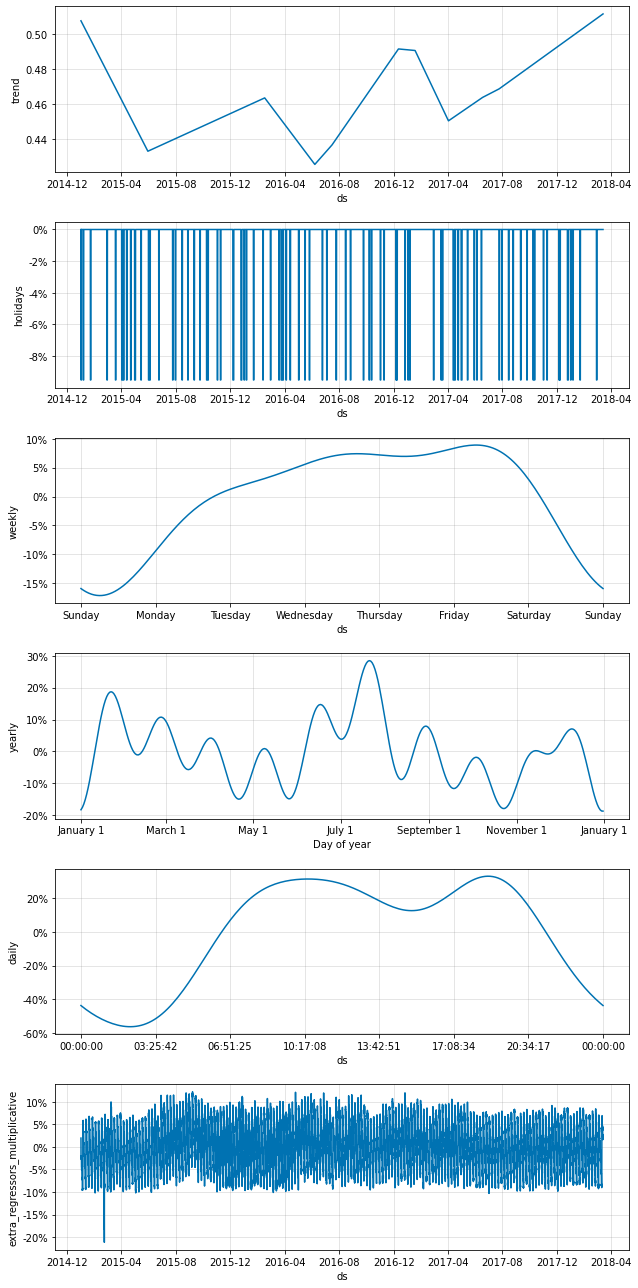

In [23]:
m.plot_components(output.loc[:trainProphet.shape[0],:]);

# Save results

In [ ]:
predictions = output.yhat.tail(testProphet.shape[0])
predictions = predictions[23:]

observations = testProphet['y'].reset_index(drop = True)
observations = observations[23:]

In [ ]:
newdf = pd.DataFrame({'forecast':predictions, 'actual':observations})
newdf.to_csv("gdrive/MyDrive/data/dataset/resultsProphetLGBM.csv")

# Train simple model

In [ ]:
m = Prophet(seasonality_mode='multiplicative', holidays = allHolidays, uncertainty_samples =0)

res = m.fit(trainProphet)

step = 24
predictions = list()
observations = list()

In [ ]:
#for t in range(500-step):
for t in range(testProphet.shape[0]-step):
    
    future = res.make_future_dataframe(freq='H',periods = step)
    #future = future[0:trainProphet.shape[0]].append(future.tail(1))
    output = res.predict(future)
    yhat = output.yhat.iloc[-1]
    if t%100==0:
      print(t)
    predictions.append(yhat)
    obs = testProphet.y[t+step-1]
    observations.append(obs)

    res.history = res.history.append({'ds':testProphet.ds[t], 
                                      'y': testProphet.y[t],
                                      'floor': 0, 
                                      't': 1,
                                      'y_scaled': testProphet.y[t]}, ignore_index=True)
    
    res.history.t = res.history.t.shift(periods=1, fill_value=0)
    res.history_dates[len(res.history_dates)] = testProphet.ds[t]

    res.history.drop(index=res.history.index[0], axis=0, inplace=True)
    res.history_dates.drop(index=res.history_dates.index[0], axis=0, inplace=True)

newdf = pd.DataFrame({'forecast':predictions, 'actual':observations})
newdf.to_csv("gdrive/MyDrive/data/dataset/resultsProphet.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


# Plot forecast vs actual values

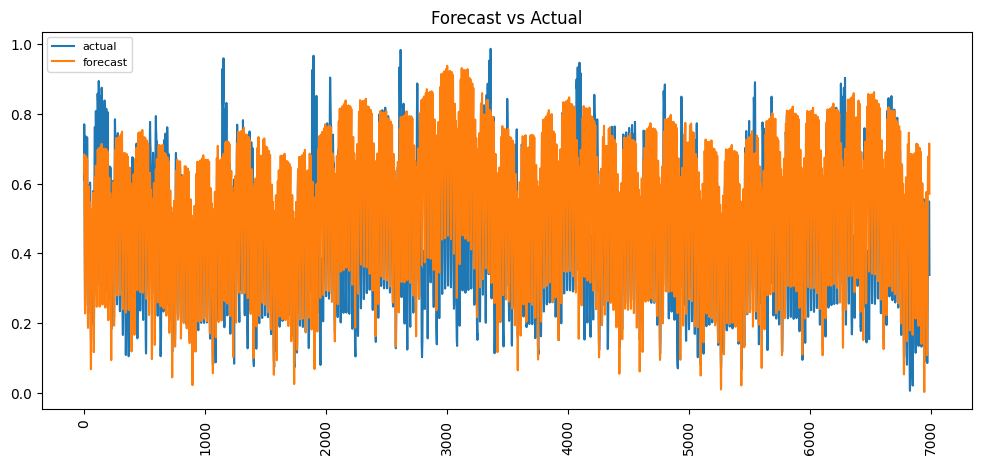

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(newdf['actual'], label='actual')
plt.plot(newdf['forecast'], label='forecast')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(fontsize=10, rotation=90)
#plt.xticks([])
plt.show()

In [ ]:
print(forecast_accuracy(newdf['forecast'], newdf['actual']))  

{'mape': 0.3264332745787427, 'mae': 0.11358526516349551, 'mse': 0.02074961729781337, 'rmse': 0.144047274524072}
